### Data loading

In [ ]:
import trimap
import pandas as pd

In [ ]:
chronos = pd.read_csv("../data/CRISPR_gene_effect.csv",index_col=0)
chronos.columns = [c.split()[0].upper() + '_Chronos' for c in chronos.columns]
expression = pd.read_csv("../data/CCLE_expression.csv", index_col=0)
expression.columns = [c.split()[0].upper()+'_Expression' for c in expression.columns]
sample_info = pd.read_csv("../data/sample_info.csv", index_col=0)
ch_ex = chronos.merge(expression, right_index=True, left_index=True).dropna()


In [4]:
id_to_name = {i:n for i, n in zip(sample_info.index, sample_info["CCLE_Name"])}
name_to_id = {n:i for i, n in zip(sample_info.index, sample_info["CCLE_Name"])}
name_to_lineage = {n:l for n, l in zip(sample_info["CCLE_Name"], sample_info["lineage"])}

### Dimensionality Reduction (Fig. 2c-e)

In [ ]:
from sklearn.preprocessing import StandardScaler

hippo_chr=['AMOTL2', 'KIRREL1', 'NF2', 'PDCD10', 'RNF146', 'TAOK1', 'PTPN14', 'MAP4K4', 'FRYL',  'LATS2',  'NRP1']
hippo_exp=['YAP1','WWTR1','CCN1','CCN2']
features = [gene + '_Chronos' for gene in hippo_chr] + [gene + '_Expression' for gene in hippo_exp] 
scaled_data = StandardScaler().fit_transform(ch_ex[features]) #Z score = 平均値との差÷標準偏差

# TriMap 
#trimap_reducer = trimap.TRIMAP(n_dims=2, n_outliers=10, n_inliers=10)
#embedding = trimap_reducer.fit_transform(scaled_data)
#Since the random seed cannot be fixed and result is slightly different in each calculation, loading csv file for replication
embedding = pd.read_csv("../trimap_hippo.csv",index_col=0).values

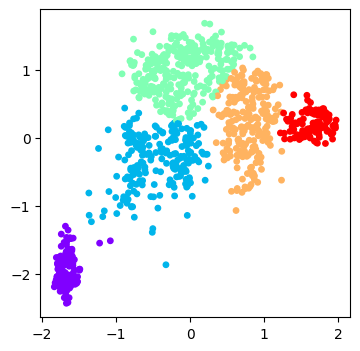

In [42]:
#Fig. 2c
import matplotlib.pyplot as plt
from sklearn.cluster import SpectralClustering
spectral = SpectralClustering(n_clusters=5, affinity='rbf', random_state=70, gamma = 30)
scaled_embedding = StandardScaler().fit_transform(embedding)
labels = spectral.fit_predict(scaled_embedding)
mapping = {4: 0, 2: 1, 1: 2, 0: 3, 3: 4}
updated_labels = [mapping[x] for x in labels]
plt.figure(figsize=(4,4))
plt.scatter(
    scaled_embedding[:, 0],
    scaled_embedding[:, 1], c =updated_labels,cmap= "rainbow", s=15)

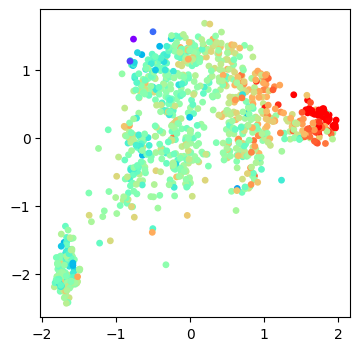

In [37]:
#Fig. 2d
plt.figure(figsize=(4,4))
plt.scatter(
    scaled_embedding[:, 0],
    scaled_embedding[:, 1], c=ch_ex['KIRREL1_Chronos'], cmap='rainbow', vmax=0.5, vmin=-0.5, s=15)


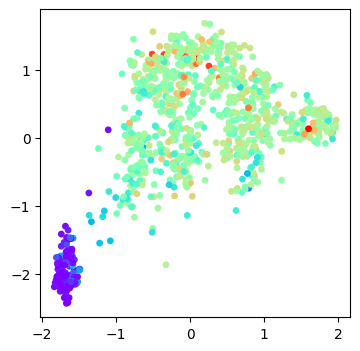

In [39]:
#Fig. 2e
plt.figure(figsize=(4,4))
plt.scatter(
    scaled_embedding[:, 0],
    scaled_embedding[:, 1], c=ch_ex['YAP1_Expression'], cmap='rainbow', vmax=10, vmin= 0, s=15)

### Modularity Fig.3a-b

In [ ]:
import numpy as np
import networkx as nx
from sklearn.neighbors import kneighbors_graph

# Build kNN graph (distances)
knn_graph = kneighbors_graph(
    scaled_embedding, 
    n_neighbors=15, 
    mode='distance', 
    include_self=False
)

# Convert distances to similarities using Gaussian kernel
sigma = np.mean(knn_graph.data)  # bandwidth
similarities = np.exp(- (knn_graph.data ** 2) / (2 * sigma ** 2))

# Replace distances with similarities
W = knn_graph.copy()
W.data = similarities

# Build weighted graph
G = nx.from_scipy_sparse_array(W)


In [65]:
#Fig.S3b
import numpy as np
import pandas as pd
import networkx as nx
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import MDS, TSNE, Isomap, LocallyLinearEmbedding
from sklearn.decomposition import PCA, FactorAnalysis, SparsePCA
import umap
from sklearn.cluster import SpectralClustering
import pacmap
from sklearn.neighbors import kneighbors_graph

dimensionality_reduction_methods = {
    "UMAP": umap.UMAP(random_state=0, n_neighbors=6, min_dist=0.08),
    "PCA": PCA(n_components=2),
    "MDS": MDS(n_components=2, random_state=0),
    "t-SNE": TSNE(n_components=2, random_state=0),
    "Isomap": Isomap(n_components=2),
    "LLE": LocallyLinearEmbedding(n_components=2, random_state=0),
    "Factor Analysis": FactorAnalysis(n_components=2),
    "Sparse PCA": SparsePCA(n_components=2, random_state=0),
    "PaCMAP": pacmap.PaCMAP(n_components=2, random_state=0, FP_ratio=1.3, n_neighbors=None),
    "Trimap": trimap.TRIMAP(n_dims=2, n_outliers=10, n_inliers=10)
}

embeddings = {}

# 結果を保存するデータフレーム
results = []
from sklearn.neighbors import radius_neighbors_graph

# 次元削減ごとにループ
for method_name, reducer in dimensionality_reduction_methods.items():
    print(method_name)
    embedding = reducer.fit_transform(scaled_data)
    scaled_embedding = StandardScaler().fit_transform(embedding)
    embeddings[method_name] = scaled_embedding
    for k in range(2,11):
        labels = SpectralClustering(n_clusters=k, affinity='rbf', random_state=70, gamma = 30).fit_predict(scaled_embedding)
        # Prepare community list from labels
        community_list = [set(np.where(labels == l)[0]) for l in np.unique(labels)]
        # Calculate modularity
        modularity_score = nx.algorithms.community.quality.modularity(G, community_list, weight='weight')
        results.append([method_name, "SpectralClustering", k, modularity_score])

df_results = pd.DataFrame(results, columns=["Dimensionality Reduction", "Clustering Method", "k", "Modularity Score"])


c:\Users\ki949\AppData\Local\Programs\Python\Python39\lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


UMAP
PCA
MDS
t-SNE
Isomap
LLE
Factor Analysis
Sparse PCA
PaCMAP
Trimap


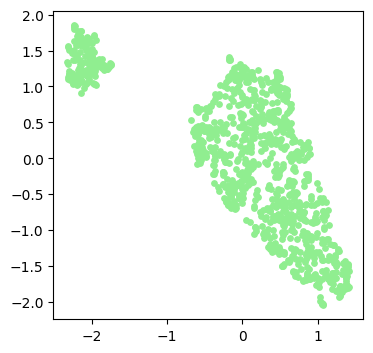

In [73]:
#Fig.S3a
method = 'UMAP'
plt.figure(figsize=(4,4))
plt.scatter(
    embeddings[method][:, 0],
    embeddings[method][:, 1], color='lightgreen', s=15)

In [62]:
df_results.sort_values('Modularity Score',ascending=False)[:10]

,Dimensionality Reduction,Clustering Method,k,Modularity Score
89,Trimap,SpectralClustering,10,0.782267
88,Trimap,SpectralClustering,9,0.778494
85,Trimap,SpectralClustering,6,0.775978
87,Trimap,SpectralClustering,8,0.774623
86,Trimap,SpectralClustering,7,0.774306
79,PaCMAP,SpectralClustering,9,0.767086
80,PaCMAP,SpectralClustering,10,0.764518
84,Trimap,SpectralClustering,5,0.761762
78,PaCMAP,SpectralClustering,8,0.760342
76,PaCMAP,SpectralClustering,6,0.752609


In [64]:
df_results.to_csv('../result/modularity.csv')

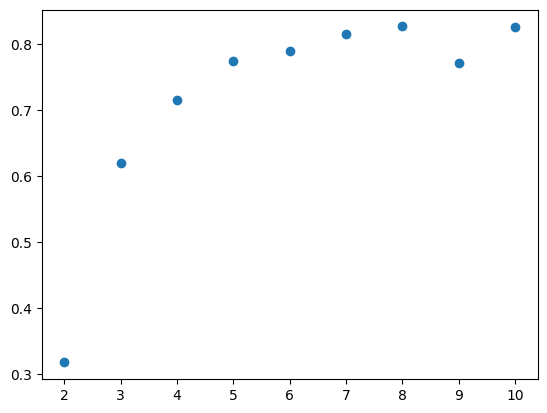

In [ ]:
#Modularity score
results = []
for k in range(2,11):
    labels = SpectralClustering(n_clusters=k, affinity='rbf', random_state=70, gamma = 30).fit_predict(scaled_embedding)
    # Prepare community list from labels
    community_list = [set(np.where(labels == l)[0]) for l in np.unique(labels)]
    # Calculate modularity
    modularity_score = nx.algorithms.community.quality.modularity(G, community_list, weight='weight')
    results.append(modularity_score)
plt.scatter(range(2,11),results)


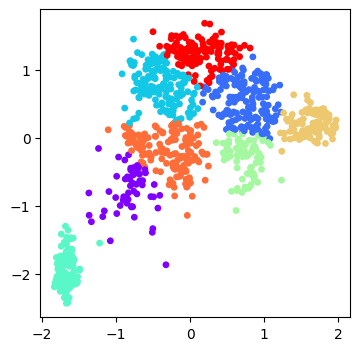

In [ ]:
#Modularity Fig.S3b




# 結果を保存するデータフレーム
results = []

# 次元削減ごとにループ
for method_name, reducer in dimensionality_reduction_methods.items():

    try:
        if isinstance(reducer, np.ndarray):
            embedding = reducer
        else:
            embedding = reducer.fit_transform(scaled_hippo1)

        scaled_embedding = StandardScaler().fit_transform(embedding)

    except Exception as e:
        print(f"{method_name} failed: {e}")
        continue

    # Spectral Clustering のみ適用
    for k in range(5,6):
        try:
            labels = SpectralClustering(n_clusters=k, affinity='nearest_neighbors', random_state=70,n_neighbors=50).fit_predict(scaled_embedding)

            # k-NN グラフの作成
            knn_graph = kneighbors_graph(scaled_embedding, n_neighbors=50, mode='connectivity')
            G = nx.from_scipy_sparse_array(knn_graph)

            # クラスタ情報をコミュニティとして渡す
            communities = {i: [] for i in range(k)}
            for idx, label in enumerate(labels):
                communities[label].append(idx)
            communities = list(communities.values())

            # Modularity 計算
            modularity_score = nx.algorithms.community.modularity(G, communities)
            results.append([method_name, "SpectralClustering", k, modularity_score])
        except Exception as e:
            print(f"{method_name} with SpectralClustering (k={k}) failed: {e}")
            continue

# 結果をデータフレームに格納
df_results = pd.DataFrame(results, columns=["Dimensionality Reduction", "Clustering Method", "k", "Modularity Score"])
